In [1]:
# _*_ coding:utf-8 _*_
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 将类似"2 3.3 4"的字符串转为list[2, 3.4, 4]
def stringLine2numbers(row):
    assert(type(row) == str) # row必须是一个string
    rowSplit = row.split() # 分割为字符串list
    rowFloat = (map(float, rowSplit)) # 将list里的每个string转为float
    return  list(rowFloat)# 返回list

In [3]:
dataPath = "./Housing Data Set/housing.data" # 原始数据的相对路径
dataString = ""
with open(dataPath) as f:
    dataString = f.readlines() # 读入全部行
    
# dataLists[i] 为第i个house相关的数据
dataLists = list(map(stringLine2numbers, dataString))

In [4]:
X = list(map(lambda lis:lis[:-1], dataLists)) # 每行取前13个数值, 即房子的属性
Y = list(map(lambda lis:lis[-1], dataLists)) # 每行取最后1个数值, 即房价

In [5]:
X = np.array(X).reshape(506, 13) # 从list转为numpy的array
Y = np.array(Y).reshape(506, 1) # 从list转为numpy的array

运行到这里, 有2个符号在后边会被用到
$
X, \ Y
$

关于X和Y的解释如下

X为所有房子的属性;
每行为单独的一个房子的属性, 有13个数据;

整个矩阵有506行, 13列;
X.shape = (506, 13)

Y为506座房子的价格;
Y.shape = (506, 1)

In [6]:
# X与Y的预处理
def normalData(Matrix):
    # Matrix -- 每一行为一个样本
    #        -- shape = (m, size) , m为样本数量, size为样本属性的数量 
    miu = np.mean(Matrix, axis = 0, keepdims=True) # 平均值, shape = (1, size)
    sigma_square = np.var(Matrix, axis = 0, keepdims=True) # 方差, shape = (1, size)
    sigma = np.sqrt(sigma_square)
    assert(miu.shape == sigma.shape)
    newMatrix = (Matrix - miu) / sigma
    return newMatrix, miu, sigma

X_normal, X_miu, X_sigma = normalData(X)
Y_normal, Y_miu, Y_sigma = normalData(Y)
# print(X_normal[505] * X_sigma + X_miu) # 数据检测
# print(X_miu)
# print(X_sigma)
# print(Y_miu)
# print(Y_sigma)
# print(Y_normal * Y_sigma + Y_miu)

In [7]:
def minMaxData(Matrix):
    # Matrix -- 每一行为一个样本
    #        -- shape = (m, size) , m为样本数量, size为样本属性的数量 
    M_min = np.min(Matrix, axis = 0) # 最小值, shape = (1, size)
    M_max = np.max(Matrix, axis = 0) # 最小值, shape = (1, size)
    M_min = M_min.reshape(1, -1)
    M_max = M_max.reshape(1, -1)
    newMatrix = (Matrix - M_min) / (M_max - M_min)
    return newMatrix, M_min, M_max

X_minmax, X_min, X_max = minMaxData(X)
Y_minmax, Y_min, Y_max = minMaxData(Y)
# print(X_minmax[0])
# print(X_min)
# print(X_max)

### LRs_predict


In [18]:
# # 辅助函数, 多了偏置的参数b
# def my_predict(X, w, b):
#     assert(X.shape[1] == w.shape[0])
#     Y_predict = np.dot(X, w) + b
#     assert(Y_predict.shape[1] == 1)
#     return Y_predict # 返回只有一列

def LRs_predict(X, w):
    # X -- shape = (m, 13)
    # w -- shape = (14, 1)
    #      为什么有14列呢? 因为最后一个为偏置b
    X_row_num = X.shape[0] # 获取X有多少行
    # newX.shape = (m, 14); 给添加一列全为1的向量到末尾
    newX = np.column_stack((X, np.ones(X_row_num))) 
    Y_predict = np.dot(newX, w).reshape(-1, 1) # Y_predict.shape = (m, 1)
    return Y_predict

### LR_learn

使用**梯度下降法**进行参数学习

$$
损失函数: \ Lost_i = \frac 1 2 (y^{\{i\}}_p - y^{\{i\}}_r)^2
$$

* $y^{\{i\}}_p$ : 对于第i个样本的预测值(predict), $y^{\{i\}}_p = X_i \times w + b$, 右乘$w$
* $y^{\{i\}}_r$ : 第i个样本的真实值(real)


$$
代价函数: \ Cost = \frac 1 m \sum^{m}_{i=1}{Lost_i}
$$

* m : 训练样本的数量

#### 梯度计算

##### b
$\frac {\partial y^{\{i\}}_p}{\partial b} = 1$

$$
\frac {\partial C}{\partial b} = 
\frac 1 m \sum^{m}_{i=1}{\frac {\partial{L_i}}{\partial b}} =  
\frac 1 m \sum^{m}_{i=1} [{(y^{\{i\}}_p - y^{\{i\}}_r)} \frac {\partial y^{\{i\}}_p}{\partial b}] =
\frac 1 m \sum^{m}_{i=1}{(y^{\{i\}}_p - y^{\{i\}}_r)} 
$$

##### w

$\frac {\partial y^{\{i\}}_p}{\partial w_j} = X^T_{ij}
\rightarrow
\frac {\partial y^{\{i\}}_p}{\partial w} = X^T_i$

$$
\frac {\partial C}{\partial w} = 
\frac 1 m \sum^{m}_{i=1}{\frac {\partial{L_i}}{\partial w}} =  
\frac 1 m \sum^{m}_{i=1}[{(y^{\{i\}}_p - y^{\{i\}}_r)} \frac {\partial y^{\{i\}}_p}{\partial w}] =
\frac 1 m \sum^{m}_{i=1}[{(y^{\{i\}}_p - y^{\{i\}}_r)} X^T_i]
$$

In [14]:
# 计算w, b的梯度
def calGradient(train_X, Y_predict, Y_real):
    # train_X -- shape = (m, 13)
    # Y_predict -- 预测值, shape = (m, 1)
    # Y_real -- 真实房价值, shape = (m, 1)
    assert(Y_predict.shape == Y_real.shape)
    Y_difference = Y_predict - Y_real # 两个不同y的差值
    db = np.mean(Y_difference) # 偏置b的梯度
    dw = np.mean(np.dot(train_X.T, Y_difference), axis = 1) # 得到13个数值
    dw = dw.reshape(-1, 1) # 转为只有1列
    return dw, db

# 计算代价Cost
def computeCost(Y_predict, Y_real):
    # Y_predict -- 预测值, shape = (m, 1)
    # Y_real -- 真实房价值, shape = (m, 1)
    assert(Y_predict.shape == Y_real.shape)
    losts = np.square(Y_predict - Y) / 2 # 每个样本, 预测值和实际值之间的误差
    cost = np.mean(losts) # 训练集的平均误差, 代价函数
    return cost

In [34]:
# 返回参数
# w -- shape = (14, 1)
# costs -- 一个list, 每次迭代前的cost(训练集的代价函数)
def learn(train_X, train_Y, rate, times):
    # train_X -- 训练样本, shape = (m, 13)
    # train_Y -- 训练标签, shape = (m, 1)
    # rate    -- 学习率
    # times   -- 迭代次数
    np.random.seed(1) # 随机数种子
    assert(type(rate) == float)
    assert(type(times) == int)
    w = np.random.randn(13, 1) * 0.01 # 权重向量
    b = np.random.randn() # 偏置
    costs = []
    for i in range(times):
        Y_predict = np.dot(train_X, w) + b
        Y_real = train_Y
        # 计算Cost
        cost = computeCost(Y_predict, Y_real)
        # print("cost after "+str(i)+" times: "+str(cost))
        costs.append(cost)
        # 计算梯度
        dw, db = calGradient(train_X, Y_predict, Y_real)
        w -= rate * dw # 更新w
        b -= rate * db # 更新b
    
    b = b.reshape(1,1)
    w = np.row_stack((w, b)) # 将偏置b添加到w中
    assert(w.shape[1] == 1)
    return w, costs
        

In [35]:
# X -- 保证数据为13列的矩阵
# Y -- 保证数据为1列的矩阵
def LR_learn(X, Y):
    assert(type(X) == numpy.ndarray)
    assert(type(Y) == numpy.ndarray)
    assert(type(len(X.shape)) == 2 and X.shape[1] == 13), "x's data size is wrong"
    assert(type(len(Y.shape)) == 2 and Y.shape[1] == 1), "y's data size is wrong"
    np.random.seed(1) # 随机数种子
    
    rate = 1 * 1e-7 # 学习率
    times = 500 # 迭代次数
    w, costs = learn(X, Y, rate, times)
    
    return w # shape = (14, 1), 最后一个参数为偏置

    

[[-0.05510319  0.1315361  -0.04314016 -0.00682874  0.01078428  0.04892543
   0.06403521  0.00694244  0.00460922  0.0014115   0.06390321  0.04922637
  -0.20017898 -0.38404234]]


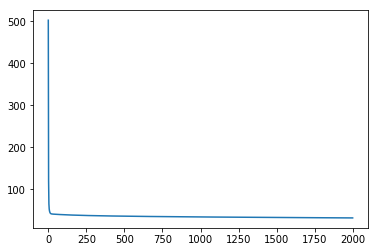

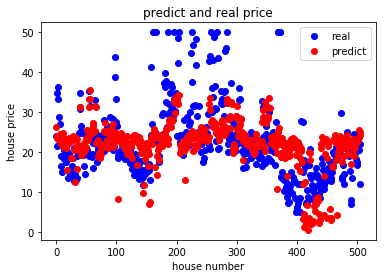

In [50]:
# my_X = np.array(range(13)).reshape(1, 13)
# my_Y = np.array(3).reshape(1,1)
w, costs = learn(X, Y, 1e-8, 2000)
# w,b,costs = learn(X_normal, Y_normal, 1 * 1e-6, 30000)
# w, costs = learn(X_minmax, Y_minmax, 1 * 1e-7, 500)

print(w.T)
plt.plot(costs)
plt.show()

# 下边是预测
Y_predict = LRs_predict(X, w)
# print("predict: "+str(LRs_predict(X[0].reshape(1, 13), w, b) * Y_sigma + Y_miu))
# Y_predict = LRs_predict(X, w, b) * Y_sigma + Y_miu
# Y_predict = LRs_predict(X, w) * (Y_max - Y_min) + Y_min
# print(LRs_predict(X, w).shape)
# print(Y_max.shape)
# print(Y_min.shape)

plt.plot(Y, 'bo', label = "real")
plt.plot(Y_predict, 'ro', label = "predict")
plt.title("predict and real price")
plt.xlabel("house number")
plt.ylabel("house price")
plt.legend()
plt.show()